# Cell Division 

## On a 2D mesh

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
import ipyvolume as ipv
%matplotlib inline

from tyssue.core.sheet import Sheet

from tyssue import config

from tyssue.geometry.planar_geometry import PlanarGeometry as geom
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.dynamics.planar_vertex_model import PlanarModel as model

from tyssue.draw.plt_draw import sheet_view
from tyssue.draw.ipv_draw import view_ipv
from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face, cell_division
from tyssue.core.objects import get_opposite

Reseting datasets values with new specs


Number of cells: 20
          edges: 116
          vertices: 54



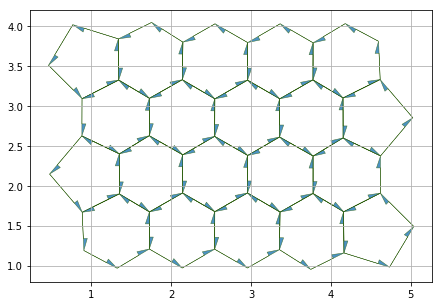

In [2]:
sheet = Sheet.planar_sheet_2d('division', 6, 6, 1, 1)
sheet.sanitize()
geom.update_all(sheet)

sheet.edge_df['opposite'] = get_opposite(sheet.edge_df)

# ## Set up the model
nondim_specs = config.dynamics.quasistatic_plane_spec()
dim_model_specs = model.dimensionalize(nondim_specs)
sheet.update_specs(dim_model_specs, reset=True)

print("Number of cells: {}\n"
      "          edges: {}\n"
      "          vertices: {}\n".format(sheet.Nf, sheet.Ne, sheet.Nv))

# ## Minimize energy
res = solver.find_energy_min(sheet, geom, model)

# ## View the result
draw_specs = config.draw.sheet_spec()
draw_specs['vert']['visible'] = False
draw_specs['edge']['head_width'] = 0.1
fig, ax = sheet_view(sheet, **draw_specs)
fig.set_size_inches(12, 5)

True


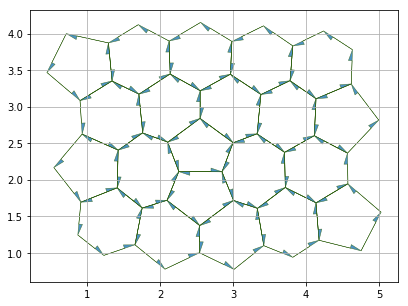

In [3]:
daughter = cell_division(sheet, 7, geom, angle=np.pi/2)

res = solver.find_energy_min(sheet, geom, model)
print(res['success'])

fig, ax = sheet_view(sheet, **draw_specs)
fig.set_size_inches(12, 5)

## Division in a 3D single layer epithelium

In [4]:
from tyssue.io.hdf5 import save_datasets, load_datasets
# redefine cell_division from monolayer related topology module
from tyssue.topology.monolayer_topology import cell_division

from tyssue.core.monolayer import Monolayer
from tyssue.geometry.bulk_geometry import BulkGeometry
from tyssue.dynamics.bulk_model import BulkModel#, set_model
#from tyssue.draw.vispy_draw import vp_view


In [5]:
datasets = load_datasets('../examples/small_ellipsoid.hf5',
                         data_names=['vert', 'edge',
                                     'face', 'cell'])
specs = config.geometry.bulk_spec()

monolayer = Monolayer('ell', datasets, specs)

# ## Settings for the quasi-static model
# ### Apical layer
apical_spec = {
    'edge': {
        'line_tension': 0.12,},
    'face': {
        'contractility': 0.04,
        'prefered_area': 0.8,
        'area_elasticity': 1.0},
    'cell': {
        'prefered_vol': 1.0,
        'vol_elasticity': 1.0},
    'settings': {
        'grad_norm_factor': 1.0,
        'nrj_norm_factor': 1.0},}

# ### Modifier for each segment of the stratum
modifiers = {
    'sagittal': {
        'edge': {
            'line_tension': 0.1},
        'face': {
            'contractility': 0.05,
            'prefered_area': 0.2}
    },
    'basal': {
        'edge': {
            'line_tension': 0.5},
        'face': {
            'contractility': 0.1,
            'prefered_area': 0.2}},
    }

#set_model(monolayer, BulkModel, apical_spec, modifiers)


In [6]:
mother = 8
daughter = cell_division(monolayer, mother, 
                         orientation='vertical')

In [7]:
monolayer.validate()

True

In [9]:

rho = np.linalg.norm(monolayer.vert_df[monolayer.coords], axis=1)
rho = pd.Series(rho, index=monolayer.vert_df.index)

colors = plt.cm.viridis(rho / rho.max())
draw_specs['edge']['color'] = colors
draw_specs['face']['color'] = '#aaaaaaaa'

fig, mesh = view_ipv(monolayer, 
                    coords=['z', 'x', 'y'], **draw_specs['edge'])
fig

Figure(anglex=0.5062883428395176, angley=-0.3430160074951778, anglez=-1.9030023132121112, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[3.017766952966369, 0.0, 0.0, 0.0, 0.0, 2.414213562373095, 0.0, 0.0, 0.0, 0.0, -1.000002000002, -1.0, 0.0, 0.0, -0.02000002000002, 0.0], matrix_world=[-0.11590144347852901, 0.3359544556984026, -0.12692005689921648, 0.0, -0.2919112935120306, -0.1658145960710157, -0.17233849888302952, 0.0, -0.20919343648174868, 0.04524781954429303, 0.31080216007415495, 0.0, -0.004689907410713073, 0.0016371769297522075, -1.3492831729499977, 1.0], meshes=[Mesh(color=array('#2b5d0a', 
      dtype='<U7'), lines=array([[ 78,  64],
       [ 64,   2],
       [  0,  78],
       ..., 
       [186, 185],
       [187, 186],
       [184, 187]], dtype=uint32), texture=None, x=array([-0.74322994, -0.54764157, -0.69203786, -0.28537221, -0.10629394,
       -0.27577504, -0.53722   , -0.14167017,  0.13034076,  0.30927197,
        0.15186534,  0.58863892,  0.74010739,  0.57580659,  0.31249336,
        0.72988736, -0.73344228, -0.13299698, -0.32270183, -0.61010431,
        0.13605271,  0.73203322,  0.5774051 ,  0.28740305, -0.77133369,
       -0.16951911, -0.33253572, -0.61952756,  0.10962478,  0.71532004,
        0.53826976,  0.27092614, -0.7541377 , -0.15106494, -0.29966319,
       -0.56345134,  0.11267021,  0.71314351,  0.57071305,  0.28847935,
       -0.73189176, -0.12985634, -0.29511843, -0.57758902,  0.12757255,
        0.72367451,  0.56178953,  0.2951533 , -0.73782305, -0.13539592,
       -0.31194545, -0.57882117,  0.12878442,  0.72606466,  0.57893581,
        0.29066424, -0.75910848, -0.15625168, -0.32200819, -0.625473  ,
        0.11921013,  0.72472257,  0.55303599,  0.28457996, -0.94786717,
        0.99126007, -0.98582495,  0.98679939, -1.03409457,  0.97167227,
       -1.01053106,  0.96957153, -1.0086347 ,  0.98022997, -0.99631276,
        0.98114101, -0.99516717,  0.98252922, -0.98517338,  0.98373716,
       -1.13166465, -1.13585227,  1.1040545 ,  1.09334083,  1.09842605,
        1.19691135, -1.21211349, -1.13099466, -1.081282  , -1.10339157,
        1.09607711,  1.19399424, -0.47646388, -0.42503673, -0.46637569,
       -0.20151595, -0.12697129, -0.20607806, -0.43034455, -0.11782978,
        0.12928906,  0.21479122,  0.12983372,  0.43367965,  0.49315417,
        0.42653338,  0.20823956,  0.49742912, -0.47023984, -0.12591814,
       -0.20918911, -0.41651675,  0.12563367,  0.48895048,  0.4238916 ,
        0.20839553, -0.49837758, -0.12669302, -0.21555478, -0.43299824,
        0.11988518,  0.49022222,  0.43633027,  0.20279069, -0.49922154,
       -0.13258643, -0.21838514, -0.4555427 ,  0.11972151,  0.48934998,
        0.42300324,  0.20253378, -0.50859827, -0.14058823, -0.22148145,
       -0.44859988,  0.11782447,  0.48778027,  0.42249187,  0.19890555,
       -0.49500382, -0.13557582, -0.21124304, -0.43630784,  0.12032211,
        0.48819923,  0.42489954,  0.20830476, -0.48859287, -0.1221421 ,
       -0.20713337, -0.41220253,  0.1267513 ,  0.4943188 ,  0.4434534 ,
        0.21239886, -0.52356286,  0.59301862, -0.53260928,  0.59200471,
       -0.59815484,  0.58850215, -0.59661125,  0.58716053, -0.59051746,
        0.59141847, -0.59096846,  0.59219786, -0.59326017,  0.58944548,
       -0.53860066,  0.5913396 , -0.62677417, -0.62982065,  0.63552268,
        0.63184609,  0.63486514,  0.65656027, -0.63890952, -0.62058943,
       -0.6028566 , -0.60252742,  0.63360771,  0.65735368,  0.65391991,
        0.21172788,  0.1670146 ,  0.45774193]), y=array([ 0.61185824,  0.77720108,  0.74310352,  0.77685156,  0.72335941,
        0.58259499,  0.60552426,  0.69958266,  0.69793886,  0.74425558,
        0.70028275,  0.72152242,  0.60661079,  0.49439201,  0.51824285,
        0.65494874,  0.34689026,  0.31374971,  0.03678079,  0.06300216,
        0.29157212,  0.23592987, -0.02577273, -0.01158011, -0.1823794 ,
       -0.26979208, -0.49788263, -0.47231105, -0.28699461, -0.30145626,
       -0.54907385, -0.54223527, -0.6413833 , -0.6

In [10]:
mother = 12
daughter = cell_division(monolayer, mother, 
                         orientation='horizontal')
monolayer.validate()

False

In [27]:
res = solver.find_energy_min(monolayer, BulkGeometry, BulkModel)

In [11]:

rho = np.linalg.norm(monolayer.vert_df[monolayer.coords], axis=1)
rho = pd.Series(rho, index=monolayer.vert_df.index)

colors = plt.cm.viridis(rho / rho.max())
draw_specs['edge']['color'] = colors
draw_specs['face']['color'] = '#aaaaaaaa'

fig, mesh = view_ipv(monolayer, 
                    coords=['z', 'x', 'y'], **draw_specs['edge'])
fig

Figure(anglex=0.15764717376430046, angley=0.38092275977675205, anglez=-2.4493933126308587, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[3.017766952966369, 0.0, 0.0, 0.0, 0.0, 2.414213562373095, 0.0, 0.0, 0.0, 0.0, -1.000002000002, -1.0, 0.0, 0.0, -0.02000002000002, 0.0], matrix_world=[-0.2696916508408726, 0.22358525317901243, 0.14029714813537258, 0.0, -0.25481870159246345, -0.2728549821733028, -0.054998452425996935, 0.0, 0.06885553378467744, -0.1340411690914417, 0.34597560926045584, 0.0, -0.003463464390771407, -0.0013933590559695242, -0.49310896949015637, 1.0], meshes=[Mesh(color=array('#2b5d0a', 
      dtype='<U7'), lines=array([[ 78,  64],
       [ 64,   2],
       [  0,  78],
       ..., 
       [186, 185],
       [187, 186],
       [184, 187]], dtype=uint32), texture=None, x=array([-0.74322994, -0.54764157, -0.69203786, -0.28537221, -0.10629394,
       -0.27577504, -0.53722   , -0.14167017,  0.13034076,  0.30927197,
        0.15186534,  0.58863892,  0.74010739,  0.57580659,  0.31249336,
        0.72988736, -0.73344228, -0.13299698, -0.32270183, -0.61010431,
        0.13605271,  0.73203322,  0.5774051 ,  0.28740305, -0.77133369,
       -0.16951911, -0.33253572, -0.61952756,  0.10962478,  0.71532004,
        0.53826976,  0.27092614, -0.7541377 , -0.15106494, -0.29966319,
       -0.56345134,  0.11267021,  0.71314351,  0.57071305,  0.28847935,
       -0.73189176, -0.12985634, -0.29511843, -0.57758902,  0.12757255,
        0.72367451,  0.56178953,  0.2951533 , -0.73782305, -0.13539592,
       -0.31194545, -0.57882117,  0.12878442,  0.72606466,  0.57893581,
        0.29066424, -0.75910848, -0.15625168, -0.32200819, -0.625473  ,
        0.11921013,  0.72472257,  0.55303599,  0.28457996, -0.94786717,
        0.99126007, -0.98582495,  0.98679939, -1.03409457,  0.97167227,
       -1.01053106,  0.96957153, -1.0086347 ,  0.98022997, -0.99631276,
        0.98114101, -0.99516717,  0.98252922, -0.98517338,  0.98373716,
       -1.13166465, -1.13585227,  1.1040545 ,  1.09334083,  1.09842605,
        1.19691135, -1.21211349, -1.13099466, -1.081282  , -1.10339157,
        1.09607711,  1.19399424, -0.47646388, -0.42503673, -0.46637569,
       -0.20151595, -0.12697129, -0.20607806, -0.43034455, -0.11782978,
        0.12928906,  0.21479122,  0.12983372,  0.43367965,  0.49315417,
        0.42653338,  0.20823956,  0.49742912, -0.47023984, -0.12591814,
       -0.20918911, -0.41651675,  0.12563367,  0.48895048,  0.4238916 ,
        0.20839553, -0.49837758, -0.12669302, -0.21555478, -0.43299824,
        0.11988518,  0.49022222,  0.43633027,  0.20279069, -0.49922154,
       -0.13258643, -0.21838514, -0.4555427 ,  0.11972151,  0.48934998,
        0.42300324,  0.20253378, -0.50859827, -0.14058823, -0.22148145,
       -0.44859988,  0.11782447,  0.48778027,  0.42249187,  0.19890555,
       -0.49500382, -0.13557582, -0.21124304, -0.43630784,  0.12032211,
        0.48819923,  0.42489954,  0.20830476, -0.48859287, -0.1221421 ,
       -0.20713337, -0.41220253,  0.1267513 ,  0.4943188 ,  0.4434534 ,
        0.21239886, -0.52356286,  0.59301862, -0.53260928,  0.59200471,
       -0.59815484,  0.58850215, -0.59661125,  0.58716053, -0.59051746,
        0.59141847, -0.59096846,  0.59219786, -0.59326017,  0.58944548,
       -0.53860066,  0.5913396 , -0.62677417, -0.62982065,  0.63552268,
        0.63184609,  0.63486514,  0.65656027, -0.63890952, -0.62058943,
       -0.6028566 , -0.60252742,  0.63360771,  0.65735368,  0.65391991,
        0.21172788,  0.1670146 ,  0.45774193]), y=array([ 0.61185824,  0.77720108,  0.74310352,  0.77685156,  0.72335941,
        0.58259499,  0.60552426,  0.69958266,  0.69793886,  0.74425558,
        0.70028275,  0.72152242,  0.60661079,  0.49439201,  0.51824285,
        0.65494874,  0.34689026,  0.31374971,  0.03678079,  0.06300216,
        0.29157212,  0.23592987, -0.02577273, -0.01158011, -0.1823794 ,
       -0.26979208, -0.49788263, -0.47231105, -0.28699461, -0.30145626,
       -0.54907385, -0.54223527, -0.6413833 , -

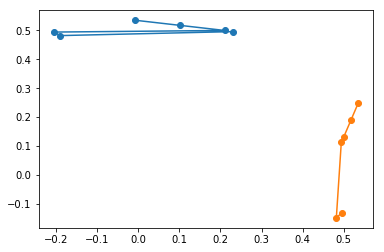

In [16]:
fig, ax = plt.subplots()
last_verts = monolayer.vert_df.loc[monolayer.Nv-6:]
ax.plot(monolayer.vert_df.loc[monolayer.Nv-6:, 'x'],
        monolayer.vert_df.loc[monolayer.Nv-6:, 'y'], '-o')
ax.plot(monolayer.vert_df.loc[monolayer.Nv-6:, 'y'],
        monolayer.vert_df.loc[monolayer.Nv-6:, 'z'], '-o')
